# West Nile Virus in Chicago

### Goal: Predict when and where various species of mosquitos will test positive for West Nile Virus within the city of Chicago.

### Background:

West Nile virus is a disease that is predominately spread to humans through infected mosquitos.  About 20% of people who are infected develop symptoms which can range from a fever to a serious neurological illness and even death. 

The Chicago Department of Public Health has set up Traps around the City of Chicago to capture mosquitos.  Those traps are checked weekly and a count is made of the number of mosquitos found and whether or not any of them tested positive for West Nile (a simple yes/no boolean flag)

### Mosquito Lifecycle

Mosquitos start to emerge from hiberation in May, peak in roughly Mid-August but continue to breed all the way through until September.  The two most common species of mosquito found in the Chicago area are Culex Pipiens and Culex Restuans, although it is mainly pipiens that feeds on humans.  Depending on weather conditions, it can take between 4 days and a week for eggs to hatch.  Generally, these mosquitos do not venture far from where they hatched -- their flight range is about 1/2 mile
(data taken from Harrison Count Health Department (www.harrisoncountyhealth.com/wnv_and_mosquitoes.htm) and http://vectorbio.rutgers.edu/outreach/species/pip2.htm

It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet. We provide you with the dataset from NOAA of the weather conditions of 2007 to 2014, during the months of the tests. 

### Data Sources
* the data for this project was taken from the Kaggle competition:https://www.kaggle.com/c/predict-west-nile-virus/.
* The Chicago Department of Public Health provided the following csv files:
* train.csv: for each of the traps, contains a weekly count of the number of mosquitos found and a boolean flag about whether or not West Nile virus was found in each.  This file contains data for 2007, 2009, 2011 and 2013
* test.csv: contains trap information for 2008, 2010, 2012 and 2014, but without counts as this is the dataset for which we need to generate prections
* weather.csv: contains daily weather observations from two weather stations in Chicago
* spray.csv: contains GIS coordinates for where the city conducted spraying for mosquitos in Chicago


### Approach
* within our trainig data, we'll treat 2013 as our prediction year for train/test split testing
* WnvPresent is what we are trying to predict (Y)

Steps taken
* Basic Cleanup and EDA
* train test split (use 2013 as our test dataset)
* use data frame mapper to imput missing values and select only the columns of interest
* calculate key weather data (cumulative precipitation for year and running average precip and temp for last 1 and 2 weeks)
* append weather data to trap dataset
* add week of year and month cols to trap dataset
* use SMOTE to generate new smaples of WNV presents
* cluster traps using HTBSCAN
* add cluster to to trap dataset
* run Classification models

### EDA Findings
* Culex Pipiens appears to be the main carrier of West Nile Virus as it is most commonly associated with the presence of west nile virus (note: we do not have a count of WNV infected mosquitos -- just a yes/no flag about whether it was present
* only 8 of 134 traps have more than 10 positive results
Mosquito Numbers:
* Culex Pipiens numbers dropped off rapidly in 2009 and 2011, although increased again slightly in 2013
* culex restuans is showing a gradual increase over time
* most counts are up in 2013 over 2011
West Nile Counts:
* numbers increased in 2013
* 2013, many observed in Culex Pipiens, Culex Pipiens/Restuans, Culex Restuans
Mosquito Counts Per Year
* in 2007, mosquito counts peaked in August, while in 2009, they peaked much earlier in June and July
* 2011 also showed a peak in July

### Results
* Best classification models were LogisticREgression and a Support Vector Machine Classifier.  The best score achieved on the validation set was with Logistic Regression

**top predictors for presence of West Nile virus**:
* week_num	(18457.99)
* two_week_avg_temp	(15469.16)
* distance_top_trap	(-8835.48)
* month	(3448.50)
* Species_CULEX PIPIENS	(2508.58)
* Species_CULEX RESTUANS -(2338.69)
* cum_precip_yr	(945.53)
* year	(-889.31)
* Trap_T115	(865.19)
* week_avg_temp	(-743.56)

**Best public leaderboard score on Kaggle**: 0.69969

In [1]:
import requests
import json
import pandas as pd
import numpy as np
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
import matplotlib.cm as cm
import matplotlib.colors as colors

#visualization
import seaborn as sns
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')

import geopy.distance

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import(
    classification_report, confusion_matrix, accuracy_score,
    f1_score,recall_score,precision_score, roc_auc_score
)


from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    RandomForestClassifier
)

from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from sklearn.preprocessing import (
    StandardScaler, LabelBinarizer, Imputer, FunctionTransformer,PolynomialFeatures, OrdinalEncoder
)

from sklearn.feature_selection import (
    VarianceThreshold, SelectKBest, SelectPercentile, 
    SelectFromModel, f_regression, RFECV
)

from sklearn.impute import SimpleImputer
from sklearn_pandas import DataFrameMapper, CategoricalImputer
from sklearn.model_selection import GridSearchCV

from sklearn.base import TransformerMixin, BaseEstimator

#from utils import separation_plot
from sklearn.pipeline import Pipeline, FeatureUnion

#from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

import catboost as cb
from catboost import CatBoostClassifier, Pool
from hdbscan import HDBSCAN
from imblearn.over_sampling import SMOTE, ADASYN
from xgboost.sklearn import XGBClassifier

In [3]:
def make_pair_plot(df_corr):
    # Set the default matplotlib figure size to 7x7:
    fix, ax = plt.subplots(figsize=(5,5))

    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(df_corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(df_corr, mask=mask, ax=ax, annot=True, cmap="BrBG")

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()

#### import the data

In [4]:

df =  pd.read_csv('assets/train.csv', parse_dates=['Date'])
df_spray = pd.read_csv('assets/spray.csv', parse_dates=['Date'])
df_weather = pd.read_csv('assets/weather.csv', parse_dates=['Date'])

## Trap dataset exploration

Train.csv contains the following columns
* Id: the id of the record
* Date: date that the WNV test is performed
* Address: approximate address of the location of trap. This is used to send to the GeoCoder. 
* Species: the species of mosquitos
* Block: block number of address
* Street: street name
* Trap: Id of the trap
* AddressNumberAndStreet: approximate address returned from GeoCoder
* Latitude, Longitude: Latitude and Longitude returned from GeoCoder
* AddressAccuracy: accuracy returned from GeoCoder
* NumMosquitos: number of mosquitoes caught in this trap
* WnvPresent: whether West Nile Virus was present in these mosquitos. 1 means WNV is present, and 0 means not present.


These test results are organized in such a way that when the number of mosquitos exceed 50, they are split into another record (another row in the dataset), such that the number of mosquitos are capped at 50. 

The location of the traps are described by the block number and street name. For your convenience, we have mapped these attributes into Longitude and Latitude in the dataset. Please note that these are derived locations. For example, Block=79, and Street= "W FOSTER AVE" gives us an approximate address of "7900 W FOSTER AVE, Chicago, IL", which translates to (41.974089,-87.824812) on the map.

Some traps are "satellite traps". These are traps that are set up near (usually within 6 blocks) an established trap to enhance surveillance efforts. Satellite traps are postfixed with letters. For example, T220A is a satellite trap to T220. 


In [5]:
df.head()

Date                                            Address  \
0 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2 2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   
3 2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
4 2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2          CULEX RESTUANS     62    N MANDELL AVE  T007   
3  CULEX PIPIENS/RESTUANS     79     W FOSTER AVE  T015   
4          CULEX RESTUANS     79     W FOSTER AVE  T015   

              AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
2   6200  N MANDELL AVE, Chicago, IL  41.994991 -87.769279                9   
3    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   
4    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   

   NumMosquitos  WnvPresent  
0             1           0  
1             1           0  
2             1           0  
3             1           0  
4             4           0

* This dataset is imbalanced -- there are many more cases of negative results than positive results for the presence of West Nile virus.  We will need to take action to address this imbalance prior to training a model

In [6]:
df['WnvPresent'].value_counts()

0    9955
1     551
Name: WnvPresent, dtype: int64

* no missing values

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
Date                      10506 non-null datetime64[ns]
Address                   10506 non-null object
Species                   10506 non-null object
Block                     10506 non-null int64
Street                    10506 non-null object
Trap                      10506 non-null object
AddressNumberAndStreet    10506 non-null object
Latitude                  10506 non-null float64
Longitude                 10506 non-null float64
AddressAccuracy           10506 non-null int64
NumMosquitos              10506 non-null int64
WnvPresent                10506 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4), object(5)
memory usage: 985.0+ KB


* There are 7 species of mosquito found, but the vast majority of mosquitos are either pipiens or restuans

In [8]:
df['Species'].value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

* Culex Pipiens appears to be the main carrier of West Nile Virus as it is most commonly associated with the presence of west nile virus (note: we do not have a count of WNV infected mosquitos -- just a yes/no flag about whether it was present

In [9]:
df.groupby('Species').sum()['WnvPresent']/df.groupby('Species').count()['WnvPresent']

Species
CULEX ERRATICUS           0.000000
CULEX PIPIENS             0.088922
CULEX PIPIENS/RESTUANS    0.055135
CULEX RESTUANS            0.017883
CULEX SALINARIUS          0.000000
CULEX TARSALIS            0.000000
CULEX TERRITANS           0.000000
Name: WnvPresent, dtype: float64

#### notes on trap
* Some traps are "satellite traps". These are traps that are set up near (usually within 6 blocks) an established trap to enhance surveillance efforts. Satellite traps are postfixed with letters. For example, T220A is a satellite trap to T220. 
* 136 unique Traps
* for now, will combine satellite traps with the count for the main trap

In [10]:
df['Trap'].value_counts()[0:10]

T900    750
T115    542
T138    314
T002    185
T135    183
T054    163
T128    160
T151    156
T212    152
T090    151
Name: Trap, dtype: int64

### Trap Dataset Cleanup
* convert Date column to DateTime
* merge satellite traps into the main trap by dropping the letter suffix


In [11]:
def trap_data_cleanup(X):
    '''
    X = data frame to be cleaned up
    converts date column to date time
    combine satelite traps into main trap
    '''
    X['Date'] = pd.to_datetime(X['Date'])
    X['Trap']=X['Trap'].apply(lambda x: x.replace('A','').replace('B','').replace('C','') )

    return X
    

In [12]:
# perform cleanup
df=trap_data_cleanup(df)


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
Date                      10506 non-null datetime64[ns]
Address                   10506 non-null object
Species                   10506 non-null object
Block                     10506 non-null int64
Street                    10506 non-null object
Trap                      10506 non-null object
AddressNumberAndStreet    10506 non-null object
Latitude                  10506 non-null float64
Longitude                 10506 non-null float64
AddressAccuracy           10506 non-null int64
NumMosquitos              10506 non-null int64
WnvPresent                10506 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4), object(5)
memory usage: 985.0+ KB


## Spray data Exploration
* The City of Chicago also does spraying to kill mosquitos. This dataset includes the GIS coordinates and dates for areas sprayed in 2011 and 2013

Columns
* Date, Time: the date and time of the spray
* Latitude, Longitude: the Latitude and Longitude of the spray

In [14]:
df_spray.head()

Date        Time   Latitude  Longitude
0 2011-08-29  6:56:58 PM  42.391623 -88.089163
1 2011-08-29  6:57:08 PM  42.391348 -88.089163
2 2011-08-29  6:57:18 PM  42.391022 -88.089157
3 2011-08-29  6:57:28 PM  42.390637 -88.089158
4 2011-08-29  6:57:38 PM  42.390410 -88.088858

In [15]:
df_spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
Date         14835 non-null datetime64[ns]
Time         14251 non-null object
Latitude     14835 non-null float64
Longitude    14835 non-null float64
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 463.7+ KB


### Spray Data Clean up
* need to convert date column to datetime
* we are missing some Time values.  it seems unlikely that the time of day of the spraying is likely to be a big contributor to it's effectiveness so let's drop it for now.  For what it's worth, all the missing spray times apppear to be on Sept 7th 2011

In [16]:
def spray_cleanup(X):
    '''
    Convert Date column to datetime
    drop time
    '''
    X['Date'] = pd.to_datetime(X['Date'])
    X = X.drop(columns=['Time'], axis=1)
    return X


In [17]:
df_spray=spray_cleanup(df_spray)


In [18]:
df_spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 3 columns):
Date         14835 non-null datetime64[ns]
Latitude     14835 non-null float64
Longitude    14835 non-null float64
dtypes: datetime64[ns](1), float64(2)
memory usage: 347.8 KB


## Weather dataframe Exploration
* It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet.
* this dataset contains daily weather reports from the NOAA for the months of the test. 
* the data comes from the following two weather stations: 
Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

In [19]:
df_weather.head().T

0                    1                    2  \
Station                        1                    2                    1   
Date         2007-05-01 00:00:00  2007-05-01 00:00:00  2007-05-02 00:00:00   
Tmax                          83                   84                   59   
Tmin                          50                   52                   42   
Tavg                          67                   68                   51   
Depart                        14                    M                   -3   
DewPoint                      51                   51                   42   
WetBulb                       56                   57                   47   
Heat                           0                    0                   14   
Cool                           2                    3                    0   
Sunrise                     0448                    -                 0447   
Sunset                      1849                    -                 1850   
CodeSum                                                                 BR   
Depth                          0                    M                    0   
Water1                         M                    M                    M   
SnowFall                     0.0                    M                  0.0   
PrecipTotal                 0.00                 0.00                 0.00   
StnPressure                29.10                29.18                29.38   
SeaLevel                   29.82                29.82                30.09   
ResultSpeed                  1.7                  2.7                   13   
ResultDir                     27                   25                    4   
AvgSpeed                     9.2                  9.6                 13.4   

                               3                    4  
Station                        2                    1  
Date         2007-05-02 00:00:00  2007-05-03 00:00:00  
Tmax                          60                   66  
Tmin                          43                   46  
Tavg                          52                   56  
Depart                         M                    2  
DewPoint                      42                   40  
WetBulb                       47                   48  
Heat                          13                    9  
Cool                           0                    0  
Sunrise                        -                 0446  
Sunset                         -                 1851  
CodeSum                    BR HZ                       
Depth                          M                    0  
Water1                         M                    M  
SnowFall                       M                  0.0  
PrecipTotal                 0.00                 0.00  
StnPressure                29.44                29.39  
SeaLevel                   30.08                30.12  
ResultSpeed                 13.3                 11.7  
ResultDir                      2                    7  
AvgSpeed                    13.4                 11.9

In [20]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
Station        2944 non-null int64
Date           2944 non-null datetime64[ns]
Tmax           2944 non-null int64
Tmin           2944 non-null int64
Tavg           2944 non-null object
Depart         2944 non-null object
DewPoint       2944 non-null int64
WetBulb        2944 non-null object
Heat           2944 non-null object
Cool           2944 non-null object
Sunrise        2944 non-null object
Sunset         2944 non-null object
CodeSum        2944 non-null object
Depth          2944 non-null object
Water1         2944 non-null object
SnowFall       2944 non-null object
PrecipTotal    2944 non-null object
StnPressure    2944 non-null object
SeaLevel       2944 non-null object
ResultSpeed    2944 non-null float64
ResultDir      2944 non-null int64
AvgSpeed       2944 non-null object
dtypes: datetime64[ns](1), float64(1), int64(5), object(15)
memory usage: 506.1+ KB


* Many of the numeric columns have imported as string/object
* a check of the data dictionary indicates that these columns may contain the value "M" for missing observations and "T" for trace precipitation
* let's do a quick check of how many rows are missing precipitation (only 2), but 318 rows have trace precipation.  
* we will need to clean up these values

In [21]:
# Check for missing precipitation
df_weather[(df_weather['PrecipTotal']=='M')]

Station       Date  Tmax  Tmin Tavg Depart  DewPoint WetBulb Heat Cool  \
117        2 2007-06-28    73    61   67      M        56      61    0    2   
119        2 2007-06-29    71    56   64      M        56      60    1    0   

       ...    CodeSum Depth Water1 SnowFall PrecipTotal StnPressure SeaLevel  \
117    ...                M      M        M           M       29.43    30.07   
119    ...                M      M        M           M       29.47    30.11   

    ResultSpeed ResultDir  AvgSpeed  
117        12.2         2      13.3  
119         7.4         2       8.2  

[2 rows x 22 columns]

In [22]:
# check for trace precipitation
len(df_weather[(df_weather['PrecipTotal']=='  T')])

318

### Weather data cleanup
* convert Date column to datetime object
* handle M (missing) and T (Trace) observations for PrecipTotal and TAvg columns so that we can convert them to float for later calculations
PrecipTotal:
* for rows with missing precipitation -- see if we can grab it from the other station on that day
* encode Trace values as 0.005
* convert to Float

TAvg:
* if average temperature is missing, calculate it from that row's max and min values
* convert to float

* Note: there are many other columns that would also need to be cleaned up, for now am not planning to include them in the model and so am skipping that step


In [23]:
def do_weather_cleanup(X):
    '''
    Cleanup weather dadtaframe
    Convert Date column to DateTime
    PrecipTotal: rows with missing precipitation -- see if we can grab it from the other station on that day
    TAVg: if average temperature is missing, calculate it from that row's max and min values
    Convert PrecipTotal and Tavg columns to Float
    '''
    X['Date'] = pd.to_datetime(X['Date'])

    #######
    # Handle Precipitation total -- handle M and T values adn convert to float
    #######
    # rows with missing precipitation -- see if we can grab it from the other station on that day
    for index, row in X.loc[(X['PrecipTotal']=='M')].iterrows():
        target_station = 1 if row['Station'] ==2 else 2
        tmp = X[(X['Date']==row['Date']) & (X['Station'] ==1 )]
        if 'M' not in tmp['PrecipTotal']:
            X.loc[index,('PrecipTotal')] = tmp['PrecipTotal'].values[0]
        else:
            print('dropping row')
            X = X.drop(index=index, axis=0)

    # # encode Trace values as 0.005 (Canadian government website defines as <.2mm)
    trace_rows = X[(X['PrecipTotal']=='  T')].index
    X.loc[trace_rows, 'PrecipTotal'] = '0.005'
    # convert to float
    X['PrecipTotal']=X['PrecipTotal'].apply(lambda x: float(x))

    #####
    # Handle average temperature
    #####
    # if average temperature is missing, calculate it from that row's max and min values
    X['Tavg'] = X.apply(
        lambda row: (row['Tmax']+row['Tmin'])/2 if row['Tavg']=='M' else row['Tavg'],   axis=1
    )
    # converto float
    X['Tavg']=X['Tavg'].apply(lambda x: float(x))
    return X

In [24]:
df_weather = do_weather_cleanup(df_weather)

In [25]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
Station        2944 non-null int64
Date           2944 non-null datetime64[ns]
Tmax           2944 non-null int64
Tmin           2944 non-null int64
Tavg           2944 non-null float64
Depart         2944 non-null object
DewPoint       2944 non-null int64
WetBulb        2944 non-null object
Heat           2944 non-null object
Cool           2944 non-null object
Sunrise        2944 non-null object
Sunset         2944 non-null object
CodeSum        2944 non-null object
Depth          2944 non-null object
Water1         2944 non-null object
SnowFall       2944 non-null object
PrecipTotal    2944 non-null float64
StnPressure    2944 non-null object
SeaLevel       2944 non-null object
ResultSpeed    2944 non-null float64
ResultDir      2944 non-null int64
AvgSpeed       2944 non-null object
dtypes: datetime64[ns](1), float64(3), int64(5), object(13)
memory usage: 506.1+ KB


#### Check that weather numerical distribution looks ok
* 2 weather stations
* max temperature goes from 41 to 104, which seems reasonable for a summer data set.  it is slightly left skewed
* min temp goes from 29 to 83, which also seems reasonable.  it is slightly left skewed
* tvg goes from 54 to 85.  it appears normally distributed
* precip total goes form 0 to 6.86 inches and is right skewed
* resultspeed (wind speed) goes from 0 to 24 mph and is very slighly right skewed

Everything looks ok with the data distribution

In [26]:
df_weather.describe()

Station         Tmax         Tmin         Tavg     DewPoint  \
count  2944.000000  2944.000000  2944.000000  2944.000000  2944.000000   
mean      1.500000    76.166101    57.810462    67.239300    53.457880   
std       0.500085    11.461970    10.381939    10.538784    10.675181   
min       1.000000    41.000000    29.000000    36.000000    22.000000   
25%       1.000000    69.000000    50.000000    60.000000    46.000000   
50%       1.500000    78.000000    59.000000    69.000000    54.000000   
75%       2.000000    85.000000    66.000000    75.000000    62.000000   
max       2.000000   104.000000    83.000000    94.000000    75.000000   

       PrecipTotal  ResultSpeed    ResultDir  
count  2944.000000  2944.000000  2944.000000  
mean      0.131780     6.960666    17.494905  
std       0.393031     3.587527    10.063609  
min       0.000000     0.100000     1.000000  
25%       0.000000     4.300000     7.000000  
50%       0.000000     6.400000    19.000000  
75%       0.060000     9.200000    25.000000  
max       6.860000    24.100000    36.000000

# EDA
* now that the data has been somewhat cleaned up, let's check for interesting trends in the data

* check for correlations within the main traps data set

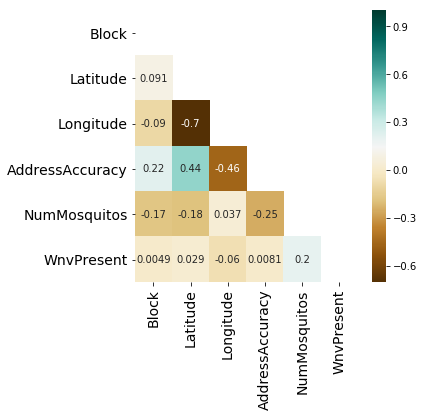

In [27]:
make_pair_plot(df.corr())

* 

#### check impact of trap and West nile
* find the traps that have the most positive results for west nile virus
* only 8 of 134 traps have more than 10 positive results

In [28]:
# df_mosq_by_trap = df[['Trap','NumMosquitos','WnvPresent']].groupby('Trap').agg('sum')
# df_mosq_by_trap.sort_values(by='WnvPresent', ascending=False, inplace=True)
# df_mosq_by_trap.reset_index(inplace=True)
# top_traps =df_mosq_by_trap[df_mosq_by_trap['WnvPresent']>10]
# top_traps
trap_coords = df[['Trap','Latitude','Longitude']].drop_duplicates()
df_mosq_by_trap = df[['Trap','NumMosquitos','WnvPresent']].groupby('Trap').agg('sum')
df_mosq_by_trap.sort_values(by='WnvPresent', ascending=False, inplace=True)
df_mosq_by_trap.reset_index(inplace=True)
top_traps =df_mosq_by_trap[df_mosq_by_trap['WnvPresent']>10]
top_traps=pd.merge(top_traps, trap_coords,  how='left', left_on=['Trap'], right_on = ['Trap'])
top_traps

Trap  NumMosquitos  WnvPresent   Latitude  Longitude
0  T900         15386          66  41.974689 -87.890615
1  T115         21668          41  41.673408 -87.599862
2  T002          3710          18  41.954690 -87.800991
3  T138          9936          16  41.726465 -87.585413
4  T003          1346          14  41.964242 -87.757639
5  T011          1311          11  41.944869 -87.832763
6  T225          2014          11  41.743402 -87.731435
7  T128          3315          11  41.704572 -87.565666

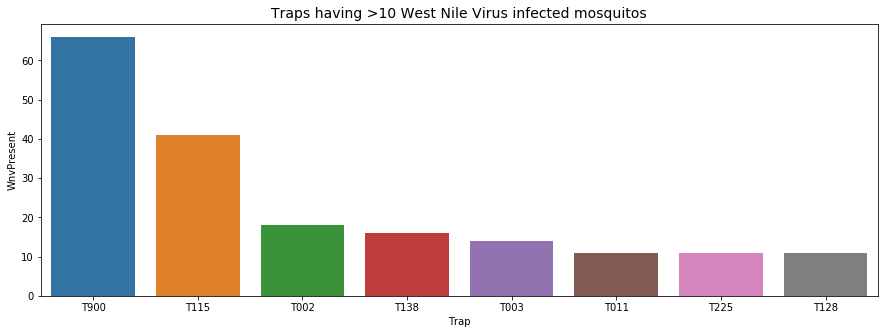

In [29]:
plt.figure(figsize=(15,5))
sns.barplot(data=df_mosq_by_trap[df_mosq_by_trap['WnvPresent']>10], x='Trap', y='WnvPresent')#, hue='Date')
plt.title("Traps having >10 West Nile Virus infected mosquitos", fontsize=14)
plt.show()

#### Check correlations of weather data and spray data with West Nile virus
* nothing too huge jumps out here

In [30]:
df_weather.corrwith(df['WnvPresent'])

Station        0.011650
Tmax          -0.025345
Tmin          -0.031487
Tavg          -0.029043
DewPoint      -0.025745
PrecipTotal   -0.033352
ResultSpeed   -0.029263
ResultDir     -0.014716
dtype: float64

In [31]:
df_spray.corrwith(df['WnvPresent'])

Latitude     0.010383
Longitude   -0.050086
dtype: float64

### Visualizing the trap locations

In [32]:
mapdata = np.loadtxt("Assets/mapdata_copyright_openstreetmap_contributors.txt")

In [33]:
locations=df[df['Date'].dt.year==2011][['Latitude','Longitude']]
locations.head()

Latitude  Longitude
6060  41.896282 -87.655232
6061  41.720848 -87.666014
6062  42.017430 -87.687769
6063  41.986921 -87.689778
6064  41.801498 -87.763416

* We were provided coordinates for hte two weather stations -- lets add this to a dataframe
* Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
* Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

In [34]:
df_weather_stations=pd.DataFrame({
    'Station':[1,2],
    'Latitude':[41.995, 41.786],
    'Longitude':[-87.933, -87.752]
})
df_weather_stations

Station  Latitude  Longitude
0        1    41.995    -87.933
1        2    41.786    -87.752

* create a plot for each year showing the location of all traps, the traps where WNV was found, the location of hte weather stations and where spraying was conducted in 2011

In [35]:
def plot_map_for_yr(X, yr):
    df_yr = X[X['Date'].dt.year==yr]
    aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
    lon_lat_box = (-88, -87.5, 41.6, 42.1)

    plt.figure(figsize=(10,14))
    plt.imshow(mapdata, 
               cmap=plt.get_cmap('gray'), 
               extent=lon_lat_box, 
               aspect=aspect)

    locations = df_yr[['Longitude', 'Latitude']].drop_duplicates().values
    plt.scatter(locations[:,0], locations[:,1], marker='x', c='black')

    locations_wnv = df_yr[df_yr['WnvPresent']==1][['Longitude', 'Latitude']].drop_duplicates().values
    plt.scatter(locations_wnv[:,0], locations_wnv[:,1], marker='o', c='red')

    locations_weather = df_weather_stations[['Longitude', 'Latitude']].drop_duplicates().values
    plt.scatter(locations_weather[:,0], locations_weather[:,1], marker="D", c='green')
    
    if yr==2011:
        #include spray location
        df_2011 = df[df['Date'].dt.year==2011]
        df_spray__2011 = df_spray[(df_spray['Date'].dt.year==2011)]
        locations_spray = df_spray__2011[['Longitude', 'Latitude']].drop_duplicates().values
        plt.scatter(locations_spray[:,0], locations_spray[:,1], marker="4", c='yellow')
        
    # plot our top ten most WNV-associated traps
    
    locations_top_traps = top_traps[['Longitude', 'Latitude']].drop_duplicates().values
    plt.scatter(locations_top_traps[:,0], locations_top_traps[:,1], marker="D", c='blue')
    
    plt.title(yr)

#### Observations
* can see that the top traps for WNV association (in blue) are clustered


**LEGEND**
* red square: west nile virus detected
* black X: trap location
* blue diamond: "Top Trap" for west nile virus association
* green diamond: weather station

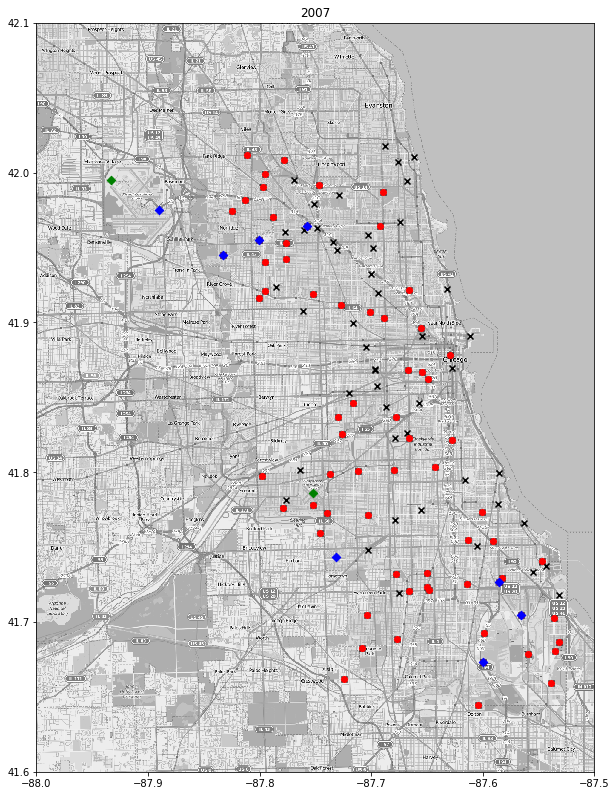

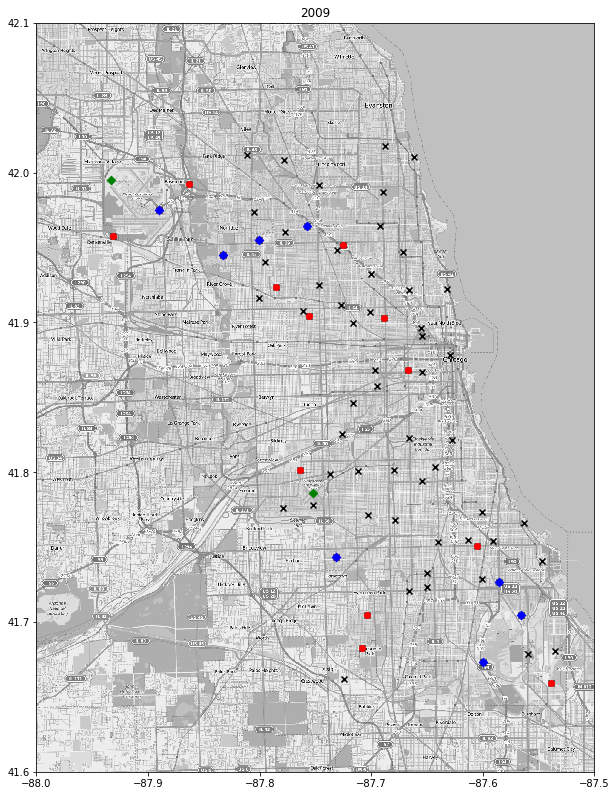

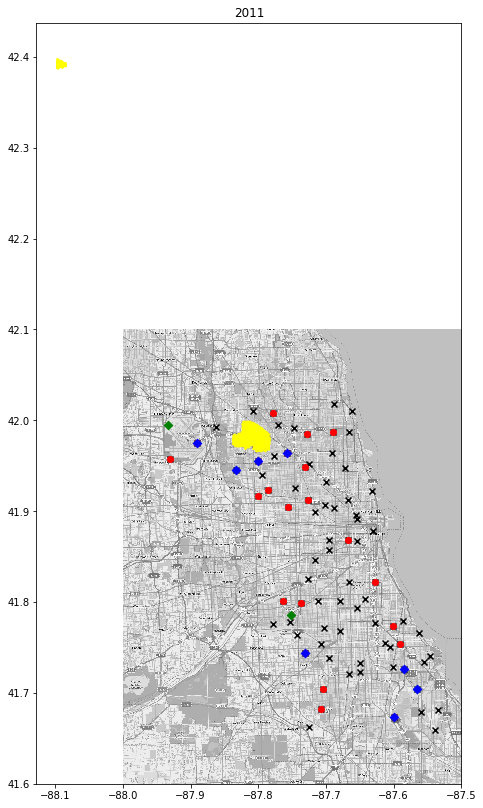

In [36]:
for ayear in [2007, 2009, 2011]:
    plot_map_for_yr(df, ayear)

### Mosquito Species found in traps

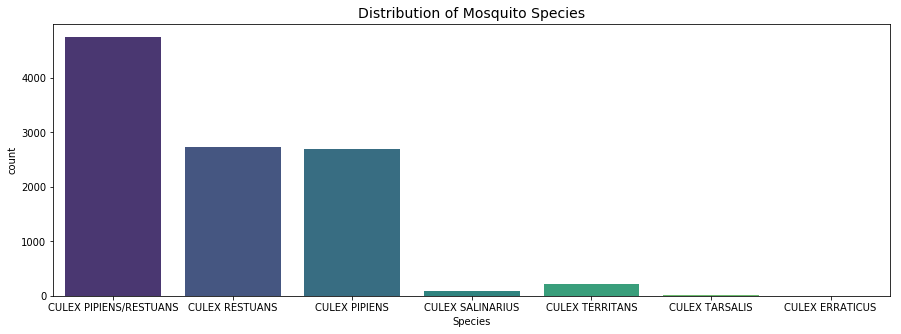

In [37]:
plt.figure(figsize=(15,5))
sns.countplot(x="Species", data=df, palette="viridis")
plt.title("Distribution of Mosquito Species", fontsize=14)
plt.show()

### Mosquito species associated with presence of West Nile
* can see below that Culex Pipiens is the main species associated with the presence of west nile

In [38]:
df_species_counts = df.groupby('Species').sum()['WnvPresent'].copy()
df_species_counts.sort_values(ascending = False,inplace=True)


In [39]:
df_species_pct_wnv = df.groupby('Species').sum()['WnvPresent']/df.groupby('Species').count()['WnvPresent'].copy()
df_species_pct_wnv.sort_values(ascending = False,inplace=True)
df_species_pct_wnv

Species
CULEX PIPIENS             0.088922
CULEX PIPIENS/RESTUANS    0.055135
CULEX RESTUANS            0.017883
CULEX TERRITANS           0.000000
CULEX TARSALIS            0.000000
CULEX SALINARIUS          0.000000
CULEX ERRATICUS           0.000000
Name: WnvPresent, dtype: float64

[Text(0.5,1,'% of Trapped Mosquitos with West Nile virus')]

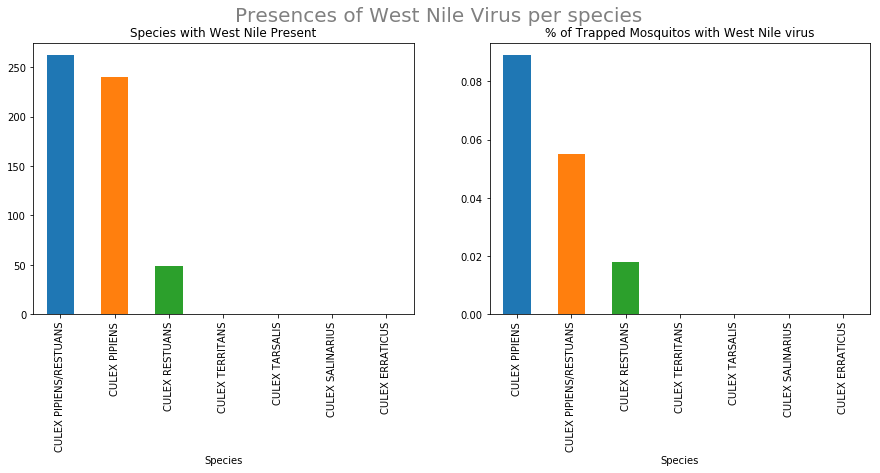

In [40]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
fig.suptitle('Presences of West Nile Virus per species', ha='center',color = 'grey',fontsize=20,va='top',) 

df_species_counts.plot(kind='bar', ax=ax1)

# Add labels to the plot
ax1.set(title="Species with West Nile Present")

df_species_pct_wnv.plot(kind='bar', ax=ax2)
ax2.set(title="% of Trapped Mosquitos with West Nile virus") # xlabel='Standardized Salaries', ylabel='Winning Percentage')

### Distribution of Mosquito species by year
* can see below that 

Mosquito Numbers:
* Culex Pipiens numbers dropped off rapidly in 2009 and 2011, although increased again slightly in 2013
* culex restuans is showing a gradual increase over time
* most counts are up in 2013 over 2011

West Nile Counts:
* numbers increased in 2013
* 2013, many observed in Culex Pipiens, Culex Pipiens/Restuans, Culex Restuans

In [41]:

df_mosq_by_year = df[['Date','Species','NumMosquitos','WnvPresent']].groupby([df['Date'].dt.year, df['Species']]).agg('sum')
df_mosq_by_year.reset_index(inplace=True)#.plot(x='Date',y='NumMosquitos')
#df_mosq_by_year

[Text(0.5,1,'Presences of West Nile Virus per Species')]

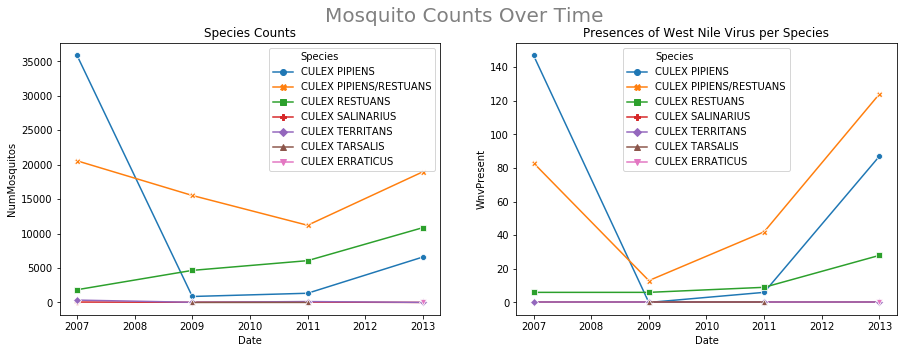

In [42]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
fig.suptitle('Mosquito Counts Over Time', ha='center',color = 'grey',fontsize=20,va='top',) 

sns.lineplot(ax=ax1,data=df_mosq_by_year,x='Date',y='NumMosquitos',hue='Species', style='Species', markers=True,dashes=False)
ax1.set(title="Species Counts")

sns.lineplot(ax=ax2,data=df_mosq_by_year,x='Date',y='WnvPresent',hue='Species', style='Species', markers=True,dashes=False)
ax2.set(title="Presences of West Nile Virus per Species")

### Compare seasonal distrubitions of mosquito counts year over year
* observations -- culex pipiens and restuans seem to share the same time characteristics (i.e. peak at roughly same time) so probably don't need to worry about distinguishing between them going forward
* in 2007, mosquito counts peaked in August, while in 2009, they peaked much earlier in June and July
* 2011 also showed a peak in July

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


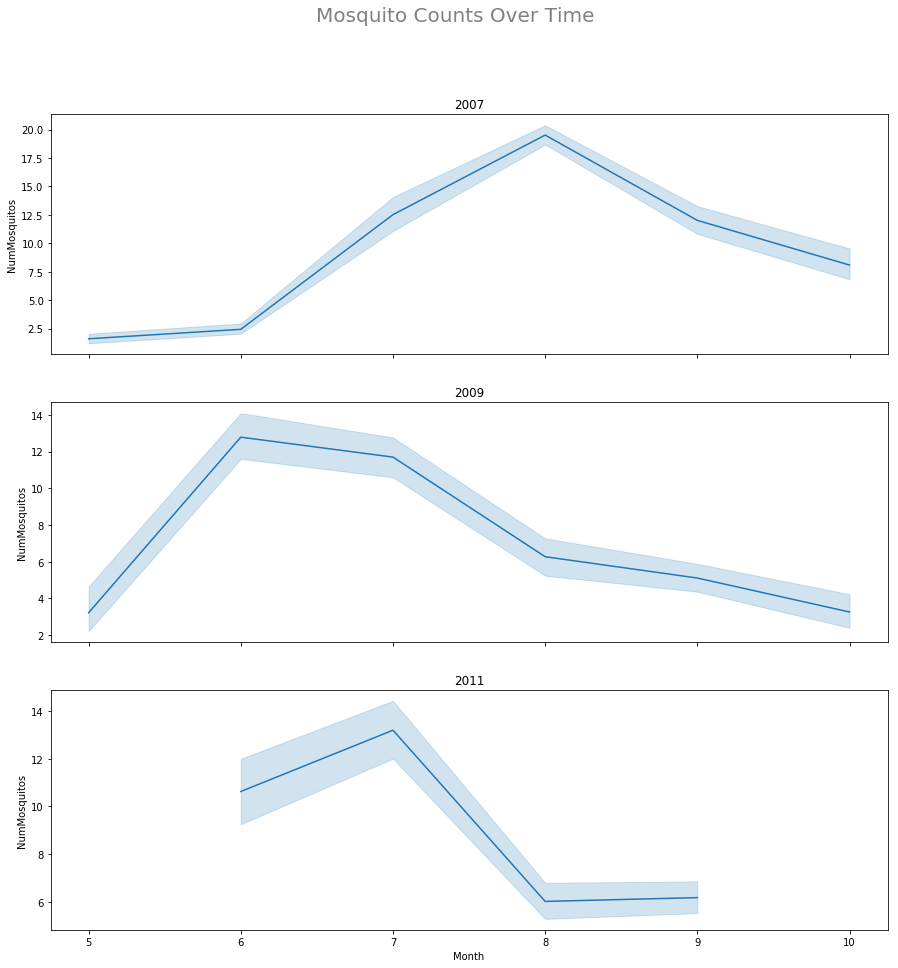

In [43]:
fig, ax = plt.subplots(nrows=3, ncols=1,figsize=(15,15),sharex=True)
df['Month']=df['Date'].dt.month
fig.suptitle('Mosquito Counts Over Time', ha='center',color = 'grey',fontsize=20,va='top',) 
cnt=0
for ayear in [2007, 2009, 2011]:
    sns.lineplot(ax=ax[cnt], data=df[(df['Date'].dt.year==ayear)],x='Month',y='NumMosquitos')#,hue='Species')
    ax[cnt].set(title=ayear)
    cnt = cnt+1

#### Compare Weather across Years
* 2009 had cool fall
* 2007 had wet august
* 2011 had a wet june

In [44]:
def plot_time_charts(X, x_col, y_col, hue, title):
    fig, ax = plt.subplots(nrows=3, ncols=1,figsize=(15,15), sharey=True)

    fig.suptitle(title, ha='center',color = 'grey',fontsize=20,va='top',) 
    cnt=0
    for ayear in [2007, 2009, 2011]:
        sns.lineplot(ax=ax[cnt], data=X[(X['Date'].dt.year==ayear)],x=x_col,y=y_col, hue=hue)
        ax[cnt].set(title=ayear)
        cnt = cnt+1

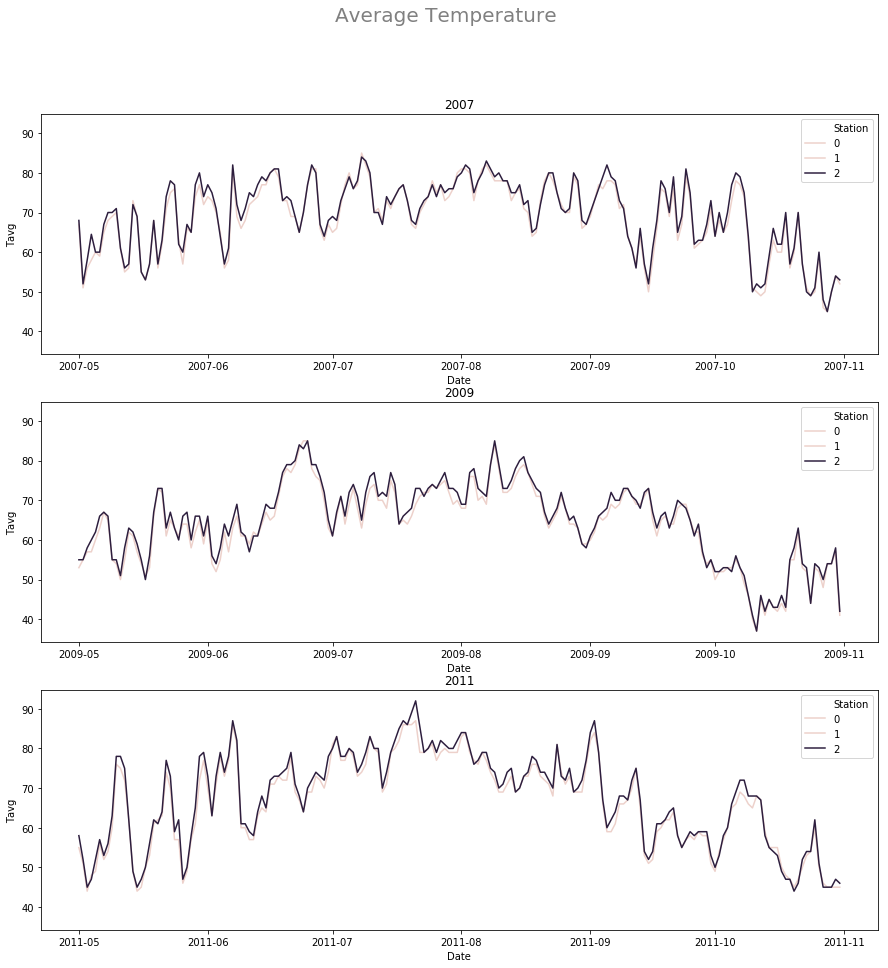

In [45]:
plot_time_charts(df_weather, 'Date', 'Tavg', 'Station', 'Average Temperature')


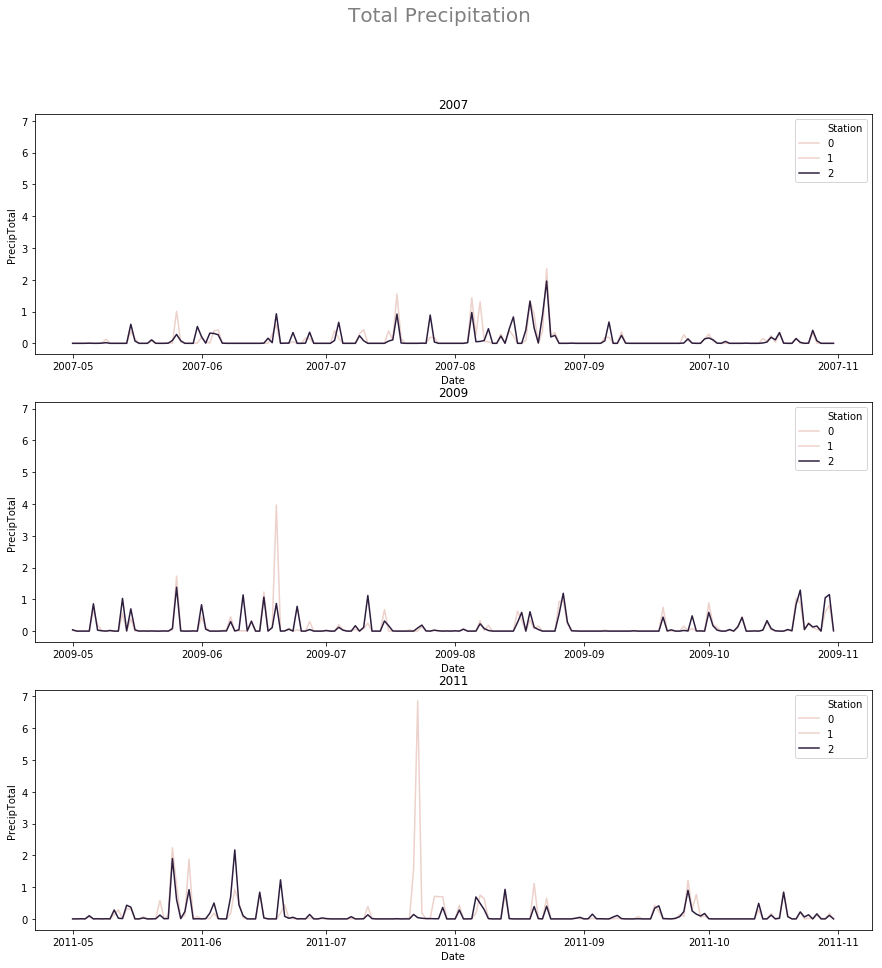

In [46]:

plot_time_charts(df_weather, 'Date', 'PrecipTotal', 'Station', 'Total Precipitation')

## Train/Test split
* training contains data for 2007, 2009, 2011, and 2013
* so let's treat 2013 as our prediction year and spin it into the X_test dataframe
* WnvPresent is what we are trying to predict (Y)
### Trap Data

In [47]:
y_test = df[df['Date'].dt.year==2013]['WnvPresent']
y_train =  df[df['Date'].dt.year<2013]['WnvPresent']
X_test = df[df['Date'].dt.year==2013].iloc[:, 0:-2]
X_train = df[df['Date'].dt.year<2013].iloc[:, 0:-2] # we have to cut off mosquito counts
df.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10506, 13), (8114, 11), (2392, 11), (8114,), (2392,))

### Spray data
* we only have spray data for 2011 and 2013
* since we are using 2013 as our test dataset for trapping, we'll do the same here

In [48]:
spray_train =df_spray[(df_spray['Date'].dt.year<2013)]
spray_test=df_spray[(df_spray['Date'].dt.year==2013)]

In [49]:
#confirm worked ok
spray_train.groupby(spray_train['Date'].dt.year).count()

Date  Latitude  Longitude
Date                           
2011  2209      2209       2209

### Weather data
* since we are using 2013 as our test dataset for trapping, we'll do the same here

In [50]:
weather_train =df_weather[(df_weather['Date'].dt.year.isin([2007, 2009, 2011]))]
weather_test=df_weather[(df_weather['Date'].dt.year==2013)]
weather_validate = df_weather[(df_weather['Date'].dt.year.isin([2008, 2010, 2012, 2014]))]

In [51]:
weather_train.groupby(weather_train['Date'].dt.year).count()

Station  Date  Tmax  Tmin  Tavg  Depart  DewPoint  WetBulb  Heat  Cool  \
Date                                                                           
2007      368   368   368   368   368     368       368      368   368   368   
2009      368   368   368   368   368     368       368      368   368   368   
2011      368   368   368   368   368     368       368      368   368   368   

        ...     CodeSum  Depth  Water1  SnowFall  PrecipTotal  StnPressure  \
Date    ...                                                                  
2007    ...         368    368     368       368          368          368   
2009    ...         368    368     368       368          368          368   
2011    ...         368    368     368       368          368          368   

      SeaLevel  ResultSpeed  ResultDir  AvgSpeed  
Date                                              
2007       368          368        368       368  
2009       368          368        368       368  
2011       368          368        368       368  

[3 rows x 22 columns]

# DataFrameMapper

In [52]:
X_train.head()

Date                                            Address  \
0 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2 2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   
3 2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
4 2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2          CULEX RESTUANS     62    N MANDELL AVE  T007   
3  CULEX PIPIENS/RESTUANS     79     W FOSTER AVE  T015   
4          CULEX RESTUANS     79     W FOSTER AVE  T015   

              AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
2   6200  N MANDELL AVE, Chicago, IL  41.994991 -87.769279                9   
3    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   
4    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   

   NumMosquitos  
0             1  
1             1  
2             1  
3             1  
4             4

In [53]:
# will not scale here as we're not done calculations yet
# NOTE: getting invalid type promotion error when Date object is included in dataframemapper
# so for now, drop it and reappend afterwards
# cannot include species and NumMosquitos as they are not known in our test set and so can't include them in our models!
trap_mapper = DataFrameMapper([
   #('Date',None),
    # drop block and address
    ('Species',[CategoricalImputer(strategy="mode"), LabelBinarizer()]),
     ('Trap',[CategoricalImputer(strategy="mode"), LabelBinarizer()]),
    (['Latitude'],None),
    (['Longitude'],None)
], df_out=True)

In [54]:
X_train_dt = pd.DataFrame(X_train['Date'])
trap_mapper.fit(X_train)
X_train= trap_mapper.transform(X_train)
X_train['Date'] = X_train_dt['Date'] # hack because dataframemapper fails on Date
X_train.head()


Species_CULEX PIPIENS  Species_CULEX PIPIENS/RESTUANS  \
0                      0                               1   
1                      0                               0   
2                      0                               0   
3                      0                               1   
4                      0                               0   

   Species_CULEX RESTUANS  Species_CULEX SALINARIUS  Species_CULEX TARSALIS  \
0                       0                         0                       0   
1                       1                         0                       0   
2                       1                         0                       0   
3                       0                         0                       0   
4                       1                         0                       0   

   Species_CULEX TERRITANS  Trap_T001  Trap_T002  Trap_T003  Trap_T004  \
0                        0          0          1          0          0   
1                        0          0          1          0          0   
2                        0          0          0          0          0   
3                        0          0          0          0          0   
4                        0          0          0          0          0   

     ...      Trap_T233  Trap_T235  Trap_T236  Trap_T237  Trap_T238  \
0    ...              0          0          0          0          0   
1    ...              0          0          0          0          0   
2    ...              0          0          0          0          0   
3    ...              0          0          0          0          0   
4    ...              0          0          0          0          0   

   Trap_T900  Trap_T903   Latitude  Longitude       Date  
0          0          0  41.954690 -87.800991 2007-05-29  
1          0          0  41.954690 -87.800991 2007-05-29  
2          0          0  41.994991 -87.769279 2007-05-29  
3          0          0  41.974089 -87.824812 2007-05-29  
4          0          0  41.974089 -87.824812 2007-05-29  

[5 rows x 143 columns]

In [55]:
X_test_dt = pd.DataFrame(X_test['Date'])
X_test= trap_mapper.transform(X_test)
X_test['Date'] = X_test_dt['Date'] # hack because dataframemapper fails on Date
X_test.head()

Species_CULEX PIPIENS  Species_CULEX PIPIENS/RESTUANS  \
8114                      0                               0   
8115                      0                               0   
8116                      0                               0   
8117                      0                               0   
8118                      0                               1   

      Species_CULEX RESTUANS  Species_CULEX SALINARIUS  \
8114                       1                         0   
8115                       1                         0   
8116                       1                         0   
8117                       1                         0   
8118                       0                         0   

      Species_CULEX TARSALIS  Species_CULEX TERRITANS  Trap_T001  Trap_T002  \
8114                       0                        0          0          1   
8115                       0                        0          0          0   
8116                       0                        0          0          0   
8117                       0                        0          0          0   
8118                       0                        0          0          0   

      Trap_T003  Trap_T004    ...      Trap_T233  Trap_T235  Trap_T236  \
8114          0          0    ...              0          0          0   
8115          0          0    ...              0          0          0   
8116          0          0    ...              0          0          0   
8117          0          0    ...              0          0          0   
8118          0          0    ...              0          0          0   

      Trap_T237  Trap_T238  Trap_T900  Trap_T903   Latitude  Longitude  \
8114          0          0          0          0  41.954690 -87.800991   
8115          0          0          0          0  41.867108 -87.654224   
8116          0          0          0          0  41.921965 -87.632085   
8117          0          0          0          0  41.720848 -87.666014   
8118          0          0          0          0  41.732984 -87.649642   

           Date  
8114 2013-06-07  
8115 2013-06-07  
8116 2013-06-07  
8117 2013-06-07  
8118 2013-06-07  

[5 rows x 143 columns]

#### Spray data - nothing needs to be done

#### weather data

In [56]:
# will not scale here as need to do calculations later on
#NOTE: getting invalid type promotion error when Date object is included in dataframemapper
# so for now, drop it and reappend afterwards
# columns to keep ['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'CodeSum', 'PrecipTotal','ResultSpeed'
weather_mapper = DataFrameMapper([
    ('Station',None),
       #('Date',None),
      (['Tmax'],[SimpleImputer(strategy='median')]),
      (['Tmin'],[SimpleImputer(strategy='median')]),
      (['Tavg'],[SimpleImputer(strategy='median')]),
      (['PrecipTotal'],[SimpleImputer(strategy='median')]),
      (['ResultSpeed'],[SimpleImputer(strategy='median')]),
#         ('Sunrise', None),
#     ('Sunset', None)

], df_out=True)

In [57]:

X_wth_train_dt = weather_train['Date']
weather_mapper = weather_mapper.fit(weather_train)
weather_train = weather_mapper.transform(weather_train)
weather_train['Date'] = X_wth_train_dt # hack because dataframemapper fails on Date
weather_train.head()

Station  Tmax  Tmin  Tavg  PrecipTotal  ResultSpeed       Date
0        1  83.0  50.0  67.0          0.0          1.7 2007-05-01
1        2  84.0  52.0  68.0          0.0          2.7 2007-05-01
2        1  59.0  42.0  51.0          0.0         13.0 2007-05-02
3        2  60.0  43.0  52.0          0.0         13.3 2007-05-02
4        1  66.0  46.0  56.0          0.0         11.7 2007-05-03

In [58]:
# repeat for weather test set
X_wth_test_dt = weather_test['Date']
weather_test = weather_mapper.transform(weather_test)
weather_test['Date'] = X_wth_test_dt # hack because dataframemapper fails on Date
weather_test.head()

Station  Tmax  Tmin  Tavg  PrecipTotal  ResultSpeed       Date
2208        1  84.0  56.0  70.0         0.00          8.0 2013-05-01
2209        2  85.0  63.0  74.0         0.00          7.7 2013-05-01
2210        1  55.0  42.0  49.0         0.11         15.2 2013-05-02
2211        2  71.0  42.0  56.5         0.00         15.8 2013-05-02
2212        1  48.0  40.0  44.0         0.05         11.2 2013-05-03

In [59]:
# repeat for weather test set
X_wth_valid_dt = weather_validate['Date']
weather_validate = weather_mapper.transform(weather_validate)
weather_validate['Date'] = X_wth_valid_dt # hack because dataframemapper fails on Date
weather_validate.head()

Station  Tmax  Tmin  Tavg  PrecipTotal  ResultSpeed       Date
368        1  74.0  48.0  61.0        0.000         10.6 2008-05-01
369        2  73.0  48.0  61.0        0.005          9.8 2008-05-01
370        1  74.0  51.0  63.0        1.280         13.8 2008-05-02
371        2  74.0  55.0  65.0        0.740         11.9 2008-05-02
372        1  56.0  43.0  50.0        0.005         10.4 2008-05-03

# Baseline model
* species seems to be a clear indicator of wnv
* It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet.
* measure area under curve

In [60]:
y_train.mean() #west nile is only found 3.85% of the time

0.03845205817106236

In [61]:
y_pred=pd.DataFrame(np.zeros(shape=len(y_test)))
roc_auc_score(y_test, y_pred)

0.5

#### score to beat: 0.5
* if we predicted that all traps will be negative for West Nile, then we will get an area under the curve of 0.5
* this is the score we need to beat

# Append weather data to our traps dataset

* for now, am only considering weather data for station 1, no matter which station a particular trap is closest to
* breeding cycle for culex species can last from 4 days to 2 weeks depending on temp/precipitation etc
* so include trailing 4 day, 1 week and 2 week temperature/rainfall data
* note, however, that traps are only emptied once a week...
* add calculated weather columns to trap data by matching on date lookup for each trap observation

Columns to add
* year
* cumulative rainfail for year
* trailing 1 week and 2 week rainfall
* trailing 1 week and 2 week avg temp

#### TODO: align traps with station
#### TODO: consider humidity
#### TODO: consider max temp

In [62]:
def add_weather_cols(X):
    '''
    calculates yearly cumulative precipitation and running weekly and biweekly average temp and precipitation
    X: weather dataframe
    '''
    # set date as index
    X.set_index('Date', inplace=True)
    # get cumulative rainfall per year
    tmp= X.groupby(X.index.to_period('y'))['PrecipTotal'].cumsum().reset_index()
    X['cum_precip_yr'] = tmp['PrecipTotal'].values
    
    
    # rolling average rainfall over previous 7 days
    X['week_avg_prec'] = pd.DataFrame(X.groupby(X.index.to_period('y'))['PrecipTotal'].rolling(7, center = False).mean().shift(1))['PrecipTotal'].values
    X['week_avg_temp'] = pd.DataFrame(X.groupby(X.index.to_period('y'))['Tavg'].rolling(7, center = False).mean().shift(1))['Tavg'].values
    # previous 14 days
    X['two_week_avg_prec'] = pd.DataFrame(X.groupby(X.index.to_period('y'))['PrecipTotal'].rolling(14, center = False).mean().shift(1))['PrecipTotal'].values
    X['two_week_avg_temp'] = pd.DataFrame(X.groupby(X.index.to_period('y'))['Tavg'].rolling(14, center = False).mean().shift(1))['Tavg'].values

#     # calculate day length
#     X['Sunset']=X['Sunset'].apply(lambda x: float(x))
#     X['Sunrise']=X['Sunrise'].apply(lambda x: float(x))
#     X['day_length'] = X['Sunset']-X['Sunrise']
    
   # At 100% relative humidity, the wet-bulb temperature is equal to the air temperature (dry-bulb temperature) and is lower at lower humidity 
    
    

    return X

In [63]:
def merge_weather_details(X_weather, X_trap):
    '''
    calculates yearly cumulative precipitation and running weekly and biweekly average temp and precipitation
    X_weather: weather dataframe
    X_trap: trap data frame to merge weather data into
    '''
    X_trap=pd.merge(X_trap, X_weather,  how='left', left_on=['Date'], right_on = ['Date'])
    X_trap.dropna()
    #'Sunset','Sunrise'
    X_trap.drop(columns=['Station','Tmax','Tmin','Tavg','PrecipTotal','ResultSpeed'], inplace=True)
    return X_trap
    

In [64]:
X_train.shape, X_test.shape


((8114, 143), (2392, 143))

In [65]:

weather_train= weather_train[weather_train['Station']==1]
weather_train=add_weather_cols(weather_train)
X_train = merge_weather_details(weather_train,X_train)

In [66]:
weather_test= weather_test[weather_test['Station']==1]
weather_test=add_weather_cols(weather_test)
X_test = merge_weather_details(weather_test,X_test)

In [67]:
X_train.shape, X_test.shape

((8114, 148), (2392, 148))

In [68]:
X_train.head()


Species_CULEX PIPIENS  Species_CULEX PIPIENS/RESTUANS  \
0                      0                               1   
1                      0                               0   
2                      0                               0   
3                      0                               1   
4                      0                               0   

   Species_CULEX RESTUANS  Species_CULEX SALINARIUS  Species_CULEX TARSALIS  \
0                       0                         0                       0   
1                       1                         0                       0   
2                       1                         0                       0   
3                       0                         0                       0   
4                       1                         0                       0   

   Species_CULEX TERRITANS  Trap_T001  Trap_T002  Trap_T003  Trap_T004  \
0                        0          0          1          0          0   
1                        0          0          1          0          0   
2                        0          0          0          0          0   
3                        0          0          0          0          0   
4                        0          0          0          0          0   

         ...          Trap_T900  Trap_T903   Latitude  Longitude       Date  \
0        ...                  0          0  41.954690 -87.800991 2007-05-29   
1        ...                  0          0  41.954690 -87.800991 2007-05-29   
2        ...                  0          0  41.994991 -87.769279 2007-05-29   
3        ...                  0          0  41.974089 -87.824812 2007-05-29   
4        ...                  0          0  41.974089 -87.824812 2007-05-29   

   cum_precip_yr  week_avg_prec  week_avg_temp  two_week_avg_prec  \
0          1.815       0.154286      67.571429           0.119286   
1          1.815       0.154286      67.571429           0.119286   
2          1.815       0.154286      67.571429           0.119286   
3          1.815       0.154286      67.571429           0.119286   
4          1.815       0.154286      67.571429           0.119286   

   two_week_avg_temp  
0          63.785714  
1          63.785714  
2          63.785714  
3          63.785714  
4          63.785714  

[5 rows x 148 columns]

### Add week number and month to our dataframe as possible precictors

In [69]:
def add_time_cols(X):
    X['week_num'] = X['Date'].dt.week# week of year (to track seasonality -- more fine grained than month)
    X['month'] = X['Date'].dt.month
    X['year'] = X['Date'].dt.year
    X.set_index('Date', inplace=True)
    return X

In [70]:
add_time_cols(X_train)
add_time_cols(X_test)

Species_CULEX PIPIENS  Species_CULEX PIPIENS/RESTUANS  \
Date                                                                
2013-06-07                      0                               0   
2013-06-07                      0                               0   
2013-06-07                      0                               0   
2013-06-07                      0                               0   
2013-06-07                      0                               1   
2013-06-07                      0                               0   
2013-06-07                      0                               0   
2013-06-07                      0                               0   
2013-06-07                      0                               1   
2013-06-07                      0                               0   
2013-06-07                      0                               1   
2013-06-07                      0                               0   
2013-06-07                      0                               0   
2013-06-07                      0                               0   
2013-06-07                      0                               0   
2013-06-07                      0                               0   
2013-06-07                      0                               0   
2013-06-07                      0                               1   
2013-06-07                      0                               0   
2013-06-07                      0                               0   
2013-06-07                      0                               0   
2013-06-07                      0                               1   
2013-06-07                      0                               0   
2013-06-07                      0                               0   
2013-06-07                      0                               0   
2013-06-07                      0                               0   
2013-06-07                      0                               1   
2013-06-07                      0                               0   
2013-06-07                      0                               0   
2013-06-07                      0                               1   
...                           ...                             ...   
2013-09-26                      0                               1   
2013-09-26                      0                               0   
2013-09-26                      1                               0   
2013-09-26                      1                               0   
2013-09-26                      0                               1   
2013-09-26                      0                               0   
2013-09-26                      1                               0   
2013-09-26                      0                               0   
2013-09-26                      0                               1   
2013-09-26                      0                               1   
2013-09-26                      1                               0   
2013-09-26                      1                               0   
2013-09-26                      1                               0   
2013-09-26                      1                               0   
2013-09-26                      0                               1   
2013-09-26                      0                               1   
2013-09-26                      1                               0   
2013-09-26                      0                               1   
2013-09-26                      0                               1   
2013-09-26                      1                               0   
2013-09-26                      0                               1   
2013-09-26                      0                               1   
2013-09-26                      0                               1   
2013-09-26                      1                               0   
2013-09-26                      0                               1   
2013-09-26

# geographical clustering of traps
* get our unique lats and longs of the traps and cluster them
* we'll use HDBScan because it supports haversine distance (i.e. longitude/latitude distances) and can calculate distances between physical locations

### sadly, this clustering seems to hurt the predictive power of the model slightly and so am removing for now

In [71]:
def get_radians_for_coord(X):
    points = X[['Latitude', 'Longitude']].drop_duplicates().values
    # convert to radians for HDBScan (per docs)
    rads = np.radians(points)


In [72]:
# get our unique lats and longs of the traps and cluster them
points = X_train[['Latitude', 'Longitude']].drop_duplicates().values

points[0:10]

array([[ 41.95469 , -87.800991],
       [ 41.994991, -87.769279],
       [ 41.974089, -87.824812],
       [ 41.9216  , -87.666455],
       [ 41.891118, -87.654491],
       [ 41.867108, -87.654224],
       [ 41.896282, -87.655232],
       [ 41.919343, -87.694259],
       [ 41.921965, -87.632085],
       [ 41.688324, -87.676709]])

In [73]:
len(points)

136

In [74]:
# convert to radians for HDBScan (per docs)
rads = np.radians(points)
rads[0:10]

array([[ 0.73224748, -1.53241638],
       [ 0.73295086, -1.5318629 ],
       [ 0.73258605, -1.53283213],
       [ 0.73166995, -1.53006828],
       [ 0.73113794, -1.52985947],
       [ 0.73071888, -1.52985481],
       [ 0.73122807, -1.5298724 ],
       [ 0.73163056, -1.53055355],
       [ 0.73167632, -1.52946841],
       [ 0.72759851, -1.53024725]])

* cluster trap locations 

In [75]:
clusterer = HDBSCAN(min_cluster_size=2, gen_min_span_tree=True,metric='haversine')
cluster_labels = clusterer.fit_predict(points)

In [76]:
# how many clusters do we have?
cluster_labels.max()


41

In [77]:
set_clusters = set(cluster_labels)

In [78]:
#create a lookup dataframe with lat/long and cluster
df_loc_clusters=pd.DataFrame({
    'Latitude':points[:,0],
    'Longitude':points[:,1],
    'Cluster': cluster_labels
})
df_loc_clusters.head()

Latitude  Longitude  Cluster
0  41.954690 -87.800991       -1
1  41.994991 -87.769279       38
2  41.974089 -87.824812       40
3  41.921600 -87.666455       22
4  41.891118 -87.654491        4

In [79]:
# plt.figure(figsize=(20,10))
# clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
#                                       edge_alpha=0.6,
#                                       node_size=80,
#                                       edge_linewidth=2)

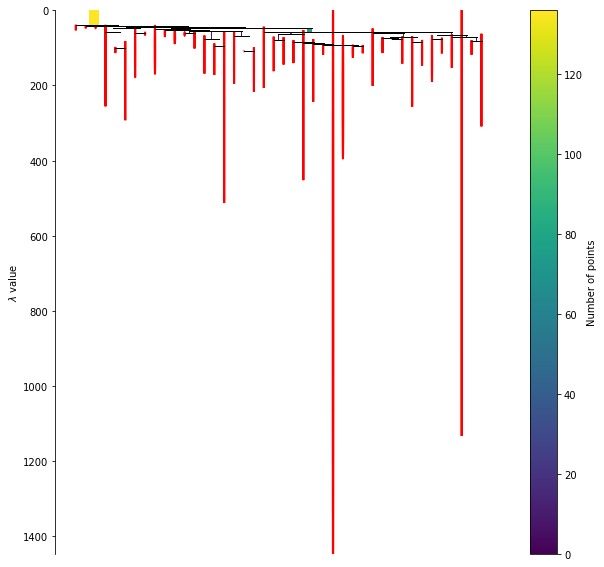

In [80]:
# plt.figure(figsize=(10,10))
# clusterer.condensed_tree_.plot(select_clusters=True)
plt.figure(figsize=(10,10))
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

In [81]:
# set color scheme for the clusters
x = np.arange(len(set_clusters))
ys = [i+x+(i*x)**2 for i in range(len(set_clusters))]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


#### Visualize clusters
* red crosses are traps not included in any cluster (outlier)

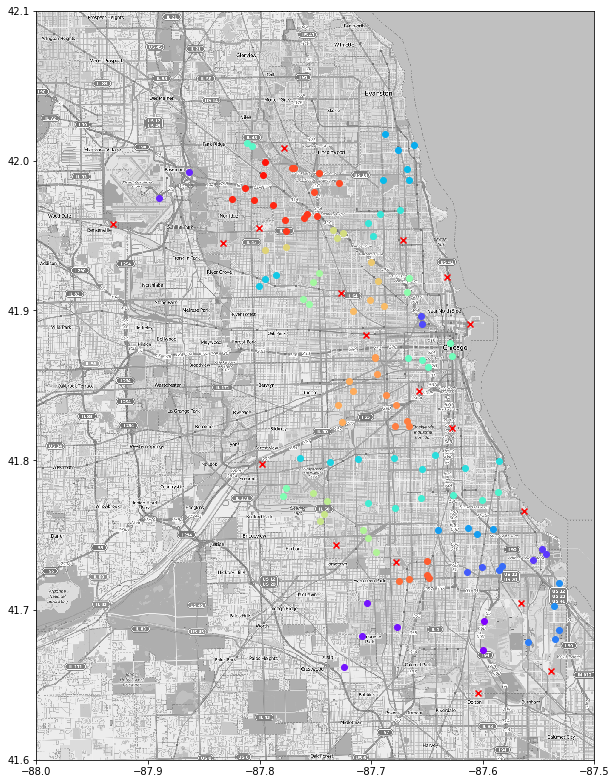

In [82]:
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

for cluster in set_clusters:
    #print(cluster)
    locations = df_loc_clusters[df_loc_clusters['Cluster']==cluster][['Longitude', 'Latitude']].drop_duplicates().values
    if cluster == -1:
        plt.scatter(locations[:,0], locations[:,1], marker='x', c='#ff0000')
    else:
        plt.scatter(locations[:,0], locations[:,1], marker='o', c=rainbow[cluster])


### assign dataframe to cluster


In [83]:
def assign_geographic_clusters(X):
    X = pd.merge(X, df_loc_clusters,  how='left', left_on=['Latitude','Longitude'], right_on = ['Latitude','Longitude'])
    # if any points aren't found, assign to cluster 1 for lack of a better idea
    X['Cluster']=X['Cluster'].fillna(-1)
    #print(X['Cluster'])
    return X

In [84]:
# X_train = assign_geographic_clusters(X_train)
# X_test = assign_geographic_clusters(X_test)

In [85]:
X_train.head()

Species_CULEX PIPIENS  Species_CULEX PIPIENS/RESTUANS  \
Date                                                                
2007-05-29                      0                               1   
2007-05-29                      0                               0   
2007-05-29                      0                               0   
2007-05-29                      0                               1   
2007-05-29                      0                               0   

            Species_CULEX RESTUANS  Species_CULEX SALINARIUS  \
Date                                                           
2007-05-29                       0                         0   
2007-05-29                       1                         0   
2007-05-29                       1                         0   
2007-05-29                       0                         0   
2007-05-29                       1                         0   

            Species_CULEX TARSALIS  Species_CULEX TERRITANS  Trap_T001  \
Date                                                                     
2007-05-29                       0                        0          0   
2007-05-29                       0                        0          0   
2007-05-29                       0                        0          0   
2007-05-29                       0                        0          0   
2007-05-29                       0                        0          0   

            Trap_T002  Trap_T003  Trap_T004  ...    Latitude  Longitude  \
Date                                         ...                          
2007-05-29          1          0          0  ...   41.954690 -87.800991   
2007-05-29          1          0          0  ...   41.954690 -87.800991   
2007-05-29          0          0          0  ...   41.994991 -87.769279   
2007-05-29          0          0          0  ...   41.974089 -87.824812   
2007-05-29          0          0          0  ...   41.974089 -87.824812   

            cum_precip_yr  week_avg_prec  week_avg_temp  two_week_avg_prec  \
Date                                                                         
2007-05-29          1.815       0.154286      67.571429           0.119286   
2007-05-29          1.815       0.154286      67.571429           0.119286   
2007-05-29          1.815       0.154286      67.571429           0.119286   
2007-05-29          1.815       0.154286      67.571429           0.119286   
2007-05-29          1.815       0.154286      67.571429           0.119286   

            two_week_avg_temp  week_num  month  year  
Date                                                  
2007-05-29          63.785714        22      5  2007  
2007-05-29          63.785714        22      5  2007  
2007-05-29          63.785714        22      5  2007  
2007-05-29          63.785714        22      5  2007  
2007-05-29          63.785714        22      5  2007  

[5 rows x 150 columns]

In [86]:
X_train.shape

(8114, 150)

## Add column for distance to one of the top WNV traps

In [87]:
top_traps

Trap  NumMosquitos  WnvPresent   Latitude  Longitude
0  T900         15386          66  41.974689 -87.890615
1  T115         21668          41  41.673408 -87.599862
2  T002          3710          18  41.954690 -87.800991
3  T138          9936          16  41.726465 -87.585413
4  T003          1346          14  41.964242 -87.757639
5  T011          1311          11  41.944869 -87.832763
6  T225          2014          11  41.743402 -87.731435
7  T128          3315          11  41.704572 -87.565666

In [88]:
# find nearest "top trap" for given trap
def find_top_trap_distance(lat, long):
    closest_pt = 10000
    for ix, trap in top_traps.iterrows():
       # print((trap['Latitude'], trap['Longitude']))
        curr_pt = geopy.distance.geodesic((trap['Latitude'], trap['Longitude']), (lat, long)).miles
        if curr_pt< closest_pt:
            closest_pt =curr_pt
    return closest_pt


In [89]:

X_train['distance_top_trap'] = X_train.apply(
    lambda row: find_top_trap_distance(row['Latitude'], row['Longitude']),   axis=1
)
X_test['distance_top_trap'] = X_test.apply(
    lambda row: find_top_trap_distance(row['Latitude'], row['Longitude']),   axis=1
)

In [90]:
X_train.sample(10)

Species_CULEX PIPIENS  Species_CULEX PIPIENS/RESTUANS  \
Date                                                                
2009-07-17                      0                               0   
2011-07-11                      0                               1   
2007-07-02                      0                               0   
2007-09-18                      0                               1   
2007-09-04                      1                               0   
2007-08-15                      0                               0   
2011-09-23                      0                               0   
2009-09-03                      0                               0   
2009-07-06                      0                               1   
2011-07-11                      0                               1   

            Species_CULEX RESTUANS  Species_CULEX SALINARIUS  \
Date                                                           
2009-07-17                       1                         0   
2011-07-11                       0                         0   
2007-07-02                       1                         0   
2007-09-18                       0                         0   
2007-09-04                       0                         0   
2007-08-15                       1                         0   
2011-09-23                       1                         0   
2009-09-03                       1                         0   
2009-07-06                       0                         0   
2011-07-11                       0                         0   

            Species_CULEX TARSALIS  Species_CULEX TERRITANS  Trap_T001  \
Date                                                                     
2009-07-17                       0                        0          0   
2011-07-11                       0                        0          0   
2007-07-02                       0                        0          0   
2007-09-18                       0                        0          0   
2007-09-04                       0                        0          0   
2007-08-15                       0                        0          0   
2011-09-23                       0                        0          0   
2009-09-03                       0                        0          0   
2009-07-06                       0                        0          0   
2011-07-11                       0                        0          0   

            Trap_T002  Trap_T003  Trap_T004        ...          Longitude  \
Date                                               ...                      
2009-07-17          0          1          0        ...         -87.757639   
2011-07-11          0          0          0        ...         -87.666901   
2007-07-02          0          0          0        ...         -87.676709   
2007-09-18          0          0          0        ...         -87.698457   
2007-09-04          0          0          0        ...         -87.703047   
2007-08-15          1          0          0        ...         -87.800991   
2011-09-23          0          0          0        ...         -87.736812   
2009-09-03          0          0          0        ...         -87.600880   
2009-07-06          0          0          0        ...         -87.666901   
2011-07-11          0          0          0        ...         -87.728492   

            cum_precip_yr  week_avg_prec  week_avg_temp  two_week_avg_prec  \
Date                                                                         
2009-07-17         12.180       0.145000      71.714286           0.095000   
2011-07-11         11.105       0.002143      77.285714           0.003571   
2007-07-02          4.125       0.044286      71.428571           0.088214   
2007-09-18         18.440       0.000714      58.857143           0.052857   
2007-09-04         17.700       0.000714      72.571429           0.236429   
2007-08-15         12.060       0.115714      77.14285

# handle unbalanced classes
* we only have a few instances of west nile disease, so let's generate some additional cases using SMOTE

In [91]:
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

len(y_resampled), y_train.shape, type(y_resampled), type(y_test)

(15604, (8114,), numpy.ndarray, pandas.core.series.Series)

In [92]:
X_train=pd.DataFrame(X_resampled, columns=X_train.columns)
X_train.head()

Species_CULEX PIPIENS  Species_CULEX PIPIENS/RESTUANS  \
0                    0.0                             1.0   
1                    0.0                             0.0   
2                    0.0                             0.0   
3                    0.0                             1.0   
4                    0.0                             0.0   

   Species_CULEX RESTUANS  Species_CULEX SALINARIUS  Species_CULEX TARSALIS  \
0                     0.0                       0.0                     0.0   
1                     1.0                       0.0                     0.0   
2                     1.0                       0.0                     0.0   
3                     0.0                       0.0                     0.0   
4                     1.0                       0.0                     0.0   

   Species_CULEX TERRITANS  Trap_T001  Trap_T002  Trap_T003  Trap_T004  \
0                      0.0        0.0        1.0        0.0        0.0   
1                      0.0        0.0        1.0        0.0        0.0   
2                      0.0        0.0        0.0        0.0        0.0   
3                      0.0        0.0        0.0        0.0        0.0   
4                      0.0        0.0        0.0        0.0        0.0   

         ...          Longitude  cum_precip_yr  week_avg_prec  week_avg_temp  \
0        ...         -87.800991          1.815       0.154286      67.571429   
1        ...         -87.800991          1.815       0.154286      67.571429   
2        ...         -87.769279          1.815       0.154286      67.571429   
3        ...         -87.824812          1.815       0.154286      67.571429   
4        ...         -87.824812          1.815       0.154286      67.571429   

   two_week_avg_prec  two_week_avg_temp  week_num  month    year  \
0           0.119286          63.785714      22.0    5.0  2007.0   
1           0.119286          63.785714      22.0    5.0  2007.0   
2           0.119286          63.785714      22.0    5.0  2007.0   
3           0.119286          63.785714      22.0    5.0  2007.0   
4           0.119286          63.785714      22.0    5.0  2007.0   

   distance_top_trap  
0           0.000000  
1           0.000000  
2           2.205251  
3           1.816075  
4           1.816075  

[5 rows x 151 columns]

In [93]:
y_train=pd.Series(y_resampled)
type(y_train), type(y_test)

(pandas.core.series.Series, pandas.core.series.Series)

## Scaling
* determined that scaling didn't help and isn't useful for the Decision Tree based classifiers that am predominately using

In [94]:
# ss = StandardScaler().fit(X_train)
# X_train = pd.DataFrame(ss.transform(X_train), columns=X_train.columns)
# # summarize transformed data

In [95]:
# X_test =pd.DataFrame(ss.transform(X_test), columns=X_test.columns)

In [96]:
# X_train.head()

# Classification Models
* competition is scored on area under the ROC curve 
* prefer to minimize False Negatives since we are trying to pick up a rare event

In [97]:
def roc(probas, true, step=0.01):
    """
    probas should be a numpy array of predict_probas
    true is a pandas series of true labels
    step is the step size for checking thresholds
    """
    
    probas = probas[:,1]  # The output of predict_proba() is an array of the probabilities for every class, but we only want the probabilities for class 1
    true = true.values    # We need to convert the class labels from a Pandas Series to a numpy array. We do this using the .values attribute
    assert(len(probas) == len(true)) # We're making sure that our probabilities vector is the same length as our true class labesl vector
    
    TPRs = [] # Setting up empty list of True Positive Rate
    FPRs = [] # Setting up empty list of False Positive Rate
    
    for i in np.arange(0.0,1.0,step): # np.arange allows us to use step sizes that are decimals
        preds_class = probas > i # Numpy arrays have a feature called 'broadcasting.' Check the documentation: https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html to see what this does.
        TP = 0 
        FP = 0
        TN = 0
        FN = 0
        for index in range(len(preds_class)): # We're comparing each prediction with each true value here

            if preds_class[index] == 1 and true[index] == 1:
                TP += 1
            elif preds_class[index] == 1 and true[index] == 0:
                FP += 1
            elif preds_class[index] == 0 and true[index] == 0:
                TN += 1 
            elif preds_class[index] == 0 and true[index] == 1:
                FN += 1
                
        TPR = TP/(TP + FN) # Calculating TPR and FPR and appending to our lists
        FPR = FP/(FP + TN)
        
        TPRs.append(TPR)
        FPRs.append(FPR)
         
    plt.rcParams['font.size'] = 14
    plt.plot(FPRs, TPRs, color="orange")
    plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('Receiver Operating Characteristic')
    plt.xlabel("False Positive Rate (1 - Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.show();

In [98]:
def store_test_results_classification (model, name, params=""):
    '''model is our the trained model to be used for scoring
    name is the name of the model
    
    '''
    
    y_pred_tst = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_tst)
        
    train_cm = confusion_matrix(y_train, y_pred_train)
    test_cm = confusion_matrix(y_test, y_pred_tst)
    
    test_f1 = f1_score(y_test, y_pred_tst, average=None)
    train_f1 = f1_score(y_train, y_pred_train, average=None)
    
    test_recall = recall_score(y_test, y_pred_tst, average=None)
    train_recall = recall_score(y_train, y_pred_train, average=None)
    
    test_prec = precision_score(y_test, y_pred_tst, average=None)
    train_prec = precision_score(y_train, y_pred_train, average=None)
    
    train_roc = roc_auc_score(y_train, y_pred_train)
    test_roc = roc_auc_score(y_test, y_pred_tst)

    
    print(f'Results for {name} with parameters {params}')
    print('accuracy for test set %s' % test_accuracy)
    print(f'ROC score for test set {test_roc}')

#     print(f'f1 score for test set:  {test_f1}')
#     print(f'recall score for test set: {test_recall}')
#     print(f'precision score for test set:  {test_prec}')
    print('\n')
    print(f'confusion matrix:\n {test_cm}')
    print('\n')
    #print(classification_report(y_test, y_pred))
    
#     # display ROC curve
#     probabilities = model.predict_proba(X_test)

#     roc(probas = probabilities, # pass in series of probabilities 
#         true = y_test,          # pass in series of true values
#         step=0.001);            # pass in step size

    return 0

In [99]:

rerun_grid_searches=True

In [100]:

#%%time
forest_params = {
    'n_estimators' :[10,100],
    'max_features':['auto','sqrt'],
    'criterion':['gini','entropy'],
    'max_depth':[ 5,10],
    'max_leaf_nodes':[20, 40,60] 
}

rfc_gridsearch = GridSearchCV(RandomForestClassifier(), forest_params, cv=5, verbose=1, n_jobs=2)

rfc_gridsearch = rfc_gridsearch.fit(X_train, y_train)
rfc_model= rfc_gridsearch.best_estimator_


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   20.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done 240 out of 240 | elapsed:  1.9min finished


In [101]:
rfc_best_params=rfc_gridsearch.best_params_
rfc_best_params

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'max_leaf_nodes': 60,
 'n_estimators': 10}

In [102]:
store_test_results_classification(rfc_model,"RandomForest")

Results for RandomForest with parameters 
accuracy for test set 0.8904682274247492
ROC score for test set 0.5355745704640988


confusion matrix:
 [[2108   45]
 [ 217   22]]




0

In [103]:
#TimeSeriesSplit
lg_params = {
    'penalty':['l2','l1'],
    'C':[.001, 1, 10],
    'solver':['liblinear'],
    'max_iter': [100],
}

lg_gridsearch = GridSearchCV(LogisticRegression(), lg_params, cv=5, verbose=1, n_jobs=2)

lg_gridsearch = lg_gridsearch.fit(X_train, y_train)
lg_model= lg_gridsearch.best_estimator_
lg_best_params = lg_gridsearch.best_params_


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  1.7min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [104]:
store_test_results_classification(lg_model,"Logistic Regression")

Results for Logistic Regression with parameters 
accuracy for test set 0.774247491638796
ROC score for test set 0.6253782306288589


confusion matrix:
 [[1747  406]
 [ 134  105]]




0

In [127]:
lg_best_params

{'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}

In [ ]:
#### check the learned coefficients

In [128]:
coefs=lg_model.coef_
coef_df=pd.DataFrame({
            'coef': sdg_model.coef_[0],
            'feature': X_train.columns
        })

coef_df['abs_coef'] = np.abs(coef_df.coef)
# sort by absolute value of coefficient (magnitude)
coef_df.sort_values('abs_coef', ascending=False, inplace=True)
coef_df.head(10)

coef                 feature      abs_coef
147  18457.990042                week_num  18457.990042
146  15469.161740       two_week_avg_temp  15469.161740
150  -8835.483919       distance_top_trap   8835.483919
148   3448.505199                   month   3448.505199
0     2508.576456   Species_CULEX PIPIENS   2508.576456
2    -2338.686689  Species_CULEX RESTUANS   2338.686689
142    945.533479           cum_precip_yr    945.533479
149   -889.312074                    year    889.312074
86     865.193700               Trap_T115    865.193700
144   -743.556980           week_avg_temp    743.556980

### Support Vector Machine

In [106]:

sdg_params = {
    'penalty':['l2','l1'],
    'alpha':[0.0001,.001, 1],
    'loss':['hinge'],
    'max_iter': [100]
}

sdg_gridsearch = GridSearchCV(SGDClassifier(), sdg_params, cv=5, verbose=1, n_jobs=2)

sdg_gridsearch = sdg_gridsearch.fit(X_train, y_train)
sdg_model= sdg_gridsearch.best_estimator_
sdg_best_params = sdg_gridsearch.best_params_


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:   16.8s finished


In [107]:
sdg_best_params

{'alpha': 0.0001, 'loss': 'hinge', 'max_iter': 100, 'penalty': 'l1'}

In [108]:
store_test_results_classification(sdg_model,"SVC")

Results for SVC with parameters 
accuracy for test set 0.7608695652173914
ROC score for test set 0.6105074752170271


confusion matrix:
 [[1719  434]
 [ 138  101]]




0

#### let's examine the learned coefficients

In [109]:

coefs=sdg_model.coef_
coef_df=pd.DataFrame({
            'coef': sdg_model.coef_[0],
            'feature': X_train.columns
        })

coef_df['abs_coef'] = np.abs(coef_df.coef)
# sort by absolute value of coefficient (magnitude)
coef_df.sort_values('abs_coef', ascending=False, inplace=True)
coef_df.head(10)

coef                 feature      abs_coef
147  18457.990042                week_num  18457.990042
146  15469.161740       two_week_avg_temp  15469.161740
150  -8835.483919       distance_top_trap   8835.483919
148   3448.505199                   month   3448.505199
0     2508.576456   Species_CULEX PIPIENS   2508.576456
2    -2338.686689  Species_CULEX RESTUANS   2338.686689
142    945.533479           cum_precip_yr    945.533479
149   -889.312074                    year    889.312074
86     865.193700               Trap_T115    865.193700
144   -743.556980           week_avg_temp    743.556980

#### CatBoost



In [110]:
cat_features=[]

In [111]:

cat_model = CatBoostClassifier(
    iterations=200,
    random_seed=63,
    learning_rate=.5,
    custom_loss=['AUC'],
    loss_function='Logloss',
    early_stopping_rounds=50
)
cat_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    verbose=False,
    plot=True
)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [112]:
store_test_results_classification(cat_model, "CatBoost", "")

Results for CatBoost with parameters 
accuracy for test set 0.8846153846153846
ROC score for test set 0.5304634770593528


confusion matrix:
 [[2095   58]
 [ 218   21]]




0

#### XGBoost

In [113]:
xgb1 = XGBClassifier(learning_rate=0.2, max_depth = 3, silent=1)

In [114]:

xgb1.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
       subsample=1)

In [115]:
store_test_results_classification(xgb1, "XGBBoost", "")

Results for XGBBoost with parameters 
accuracy for test set 0.8975752508361204
ROC score for test set 0.522784204972336


confusion matrix:
 [[2134   19]
 [ 226   13]]




0

# Generate Predictions for test.csv
* test set does not contain Mosquito counts


In [116]:
df_validate = pd.read_csv('assets/test.csv', parse_dates=['Date'])
df_validate.shape

(116293, 11)

In [117]:
# save the ids
df_final_preds = df_validate[['Id']]
df_validate=trap_data_cleanup(df_validate)
df_validate.drop(columns='Id', inplace=True)
df_validate.head()

Date                                            Address  \
0 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
3 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
4 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2           CULEX PIPIENS     41   N OAK PARK AVE  T002   
3        CULEX SALINARIUS     41   N OAK PARK AVE  T002   
4         CULEX TERRITANS     41   N OAK PARK AVE  T002   

              AddressNumberAndStreet  Latitude  Longitude  AddressAccuracy  
0  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9  
1  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9  
2  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9  
3  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9  
4  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9

In [118]:
weather_validate.shape,  df_validate.shape

((1472, 7), (116293, 10))

In [119]:
df_validate_dt = pd.DataFrame(df_validate['Date'])
df_validate= trap_mapper.transform(df_validate)
df_validate['Date'] = df_validate_dt['Date'] # hack because dataframemapper fails on Date

weather_validate= weather_validate[weather_validate['Station']==1]
weather_validate=add_weather_cols(weather_validate)


In [120]:
weather_validate.shape, df_validate.shape

((736, 11), (116293, 143))

In [121]:
df_validate = merge_weather_details(weather_validate,df_validate)

df_validate=add_time_cols(df_validate)
#df_validate = assign_geographic_clusters(df_validate)
# TODO: this is VERY slow -- need to refactor 
df_validate['distance_top_trap'] = df_validate.apply(
    lambda row: find_top_trap_distance(row['Latitude'], row['Longitude']),   axis=1
)

df_validate.head()

Species_CULEX PIPIENS  Species_CULEX PIPIENS/RESTUANS  \
Date                                                                
2008-06-11                      0                               1   
2008-06-11                      0                               0   
2008-06-11                      1                               0   
2008-06-11                      0                               0   
2008-06-11                      0                               0   

            Species_CULEX RESTUANS  Species_CULEX SALINARIUS  \
Date                                                           
2008-06-11                       0                         0   
2008-06-11                       1                         0   
2008-06-11                       0                         0   
2008-06-11                       0                         1   
2008-06-11                       0                         0   

            Species_CULEX TARSALIS  Species_CULEX TERRITANS  Trap_T001  \
Date                                                                     
2008-06-11                       0                        0          0   
2008-06-11                       0                        0          0   
2008-06-11                       0                        0          0   
2008-06-11                       0                        0          0   
2008-06-11                       0                        1          0   

            Trap_T002  Trap_T003  Trap_T004        ...          Longitude  \
Date                                               ...                      
2008-06-11          1          0          0        ...         -87.800991   
2008-06-11          1          0          0        ...         -87.800991   
2008-06-11          1          0          0        ...         -87.800991   
2008-06-11          1          0          0        ...         -87.800991   
2008-06-11          1          0          0        ...         -87.800991   

            cum_precip_yr  week_avg_prec  week_avg_temp  two_week_avg_prec  \
Date                                                                         
2008-06-11          6.785       0.306429           73.0               0.22   
2008-06-11          6.785       0.306429           73.0               0.22   
2008-06-11          6.785       0.306429           73.0               0.22   
2008-06-11          6.785       0.306429           73.0               0.22   
2008-06-11          6.785       0.306429           73.0               0.22   

            two_week_avg_temp  week_num  month  year  distance_top_trap  
Date                                                                     
2008-06-11          67.928571        24      6  2008                0.0  
2008-06-11          67.928571        24      6  2008                0.0  
2008-06-11          67.928571        24      6  2008                0.0  
2008-06-11          67.928571        24      6  2008                0.0  
2008-06-11          67.928571        24      6  2008                0.0  

[5 rows x 151 columns]

In [122]:
validate_preds = sdg_model.predict(df_validate)

In [125]:
validate_preds=lg_model.predict(df_validate)

In [126]:
df_final_preds['WnvPresent'] = pd.Series(validate_preds)
df_final_preds.to_csv("ag_preliminary.csv", index=False)
#kaggle  competitions submit -c predict-west-nile-virus -f submission.csv -m "First attempt with Month, Week and Geographic Clusters using SVM"

# Future Ideas
* mark traps as being either pipiens or restuans heavy, as it seems that pipiens is the main risk for humans 
* determine whether traps are closer to weather station 1 or 2 and provide them with the weather data for the closest weather station, rather than just providing all the traps with the data from station 1
* calculate distance from sprayed area (if spraying done in year)